In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [76]:
# Obtener la ruta absoluta del directorio actual (donde está el script o notebook)
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subimos un nivel

# Construir la ruta relativa a la carpeta "Datos"
ruta_bdd = os.path.join(base_dir, "Datos", "database.xlsx")

# Leer el archivo de datos
data = pd.read_excel(ruta_bdd, sheet_name=None)

In [77]:
# Concatenamos los dataframes de cada key:
data = pd.concat(data.values(), ignore_index=True)
print(data.shape)
data.head()

(41, 20)


,FECHA,Caudal,TPH,% Solido,Presion,Bateria,Ciclón,Medicion,horometro,camino_id,uso_230,TPH_acum,dias_230,solido_uso,carga_solidos_efectiva,ratio_tph_caudal,solido_presion,score,score_out,E
0,2019-03-18,3609.296448,4353.675418,70.596664,9.809577,BHC 1011,CyA,240.0,17987.828125,1011 CyA_2018-09-03,7.769185,17414.701673,196,805.053871,3505.532267,1.206239,692.523378,0.032372,0,1
1,2024-08-18,5618.364990,4718.561523,59.569263,10.484711,BHC 1011,CyB,233.5,50149.431641,1011 CyB_2024-07-31,5.004379,9437.123047,18,992.097028,1534.345463,0.839846,624.566522,0.021432,0,0
2,2017-11-07,3698.703006,4765.843759,70.589353,9.832086,BHC 1011,CyF,235.0,13588.043945,1011 CyF_2017-09-12,7.086742,9531.687517,56,872.902244,2019.102811,1.288518,694.040550,0.030156,0,0
3,2020-06-15,3689.816192,4116.444207,70.529620,9.718693,BHC 1011,CyG,240.0,25063.132812,1011 CyG_2019-10-08,8.229440,8232.888413,251,764.180942,1549.255011,1.115623,685.455732,0.034289,0,1
4,2024-09-10,4969.703509,4812.063802,63.001520,7.701962,BHC 1011,CyG,232.5,49058.373047,1011 CyG_2024-07-31,6.147913,14436.191406,41,881.397395,2356.554423,0.968280,485.235336,0.026443,0,0


In [78]:
data["E"].value_counts()

E
0    23
1    18
Name: count, dtype: int64

In [79]:
# Ver todas las variables disponibles en el dataset
print("Variables disponibles en el dataset:")
display(pd.DataFrame({"Variables": data.columns}))

# Ahora elige qué variables quieres usar:
selected_vars = ["uso_230", "TPH_acum", "horometro"]

Variables disponibles en el dataset:


,Variables
0,FECHA
1,Caudal
2,TPH
3,% Solido
4,Presion
5,Bateria
6,Ciclón
7,Medicion
8,horometro
9,camino_id


In [80]:
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter

# --------------------------------------------
# 1. Filtrar data con las variables seleccionadas
# --------------------------------------------
selected_data = data[selected_vars + ["dias_230", "E"]].copy()

# Convertir evento en formato de supervivencia para sksurv
selected_data["evento_supervivencia"] = list(zip(selected_data["E"].astype(bool), selected_data["dias_230"]))
y = np.array(selected_data["evento_supervivencia"], dtype=[("evento", "?"), ("tiempo", "<f8")])
X = selected_data.drop(columns=["E", "dias_230", "evento_supervivencia"])

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------
# 2. Entrenar modelo de supervivencia
# --------------------------------------------
coxboost = CoxPHSurvivalAnalysis(alpha=0.1)  # Regularización L2
coxboost.fit(X_train, y_train)
c_index = coxboost.score(X_test, y_test)
print(f"C-index del modelo CoxBoost: {c_index:.3f}")

rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=2, min_samples_leaf=1, random_state=42)
rsf.fit(X_train, y_train)
c_index = rsf.score(X_test, y_test)
print(f"C-index del modelo RSF: {c_index:.3f}")


C-index del modelo CoxBoost: 1.000
C-index del modelo RSF: 0.857


# Validación

In [81]:
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import StratifiedKFold

print("KFold con RSF:")

# Convertir `y_train["evento"]` en etiquetas para estratificación
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

for train_idx, val_idx in skf.split(X_train, y_train["evento"]):  # Estratificamos según eventos
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]

    # Entrenar modelo en cada fold
    rsf.fit(X_train_cv, y_train_cv)

    # Predicción de riesgos
    pred_risk = rsf.predict(X_val_cv)

    # Verificar que haya eventos antes de calcular C-index
    if sum(y_val_cv["evento"]) > 0:
        c_index = concordance_index_censored(y_val_cv["evento"], y_val_cv["tiempo"], -pred_risk)[0]
        c_index_scores.append(c_index)

# Resultado final
if len(c_index_scores) > 0:
    print(f"\n📊 Validación Cruzada (5-folds) - C-index medio: {np.mean(c_index_scores):.3f} ± {np.std(c_index_scores):.3f}")
else:
    print("\n⚠️ No hay suficientes eventos para calcular C-index en ningún fold. Revisa la distribución de datos.")


KFold con RSF:

📊 Validación Cruzada (5-folds) - C-index medio: 0.200 ± 0.117


In [82]:
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import StratifiedKFold

print("KFold con CoxBoost:")

# Convertir `y_train["evento"]` en etiquetas para estratificación
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

for train_idx, val_idx in skf.split(X_train, y_train["evento"]):  # Estratificamos según eventos
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]

    # Entrenar modelo en cada fold
    coxboost.fit(X_train_cv, y_train_cv)

    # Predicción de riesgos
    pred_risk = coxboost.predict(X_val_cv)

    # Verificar que haya eventos antes de calcular C-index
    if sum(y_val_cv["evento"]) > 0:
        c_index = concordance_index_censored(y_val_cv["evento"], y_val_cv["tiempo"], -pred_risk)[0]
        c_index_scores.append(c_index)

# Resultado final
if len(c_index_scores) > 0:
    print(f"\n📊 Validación Cruzada (5-folds) - C-index medio: {np.mean(c_index_scores):.3f} ± {np.std(c_index_scores):.3f}")
else:
    print("\n⚠️ No hay suficientes eventos para calcular C-index en ningún fold. Revisa la distribución de datos.")

KFold con CoxBoost:

📊 Validación Cruzada (5-folds) - C-index medio: 0.053 ± 0.069


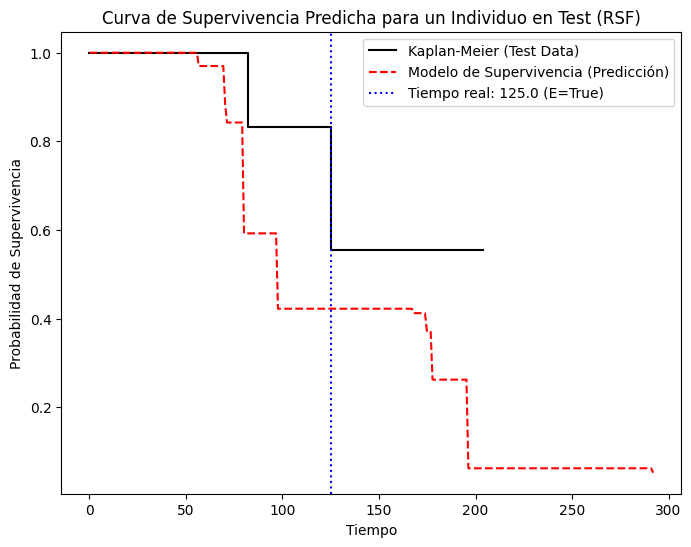

FECHA                     2018-10-02 00:00:00
Caudal                            5318.713265
TPH                                4091.05735
% Solido                            78.409096
Presion                              9.655114
Bateria                              BHC 1012
Ciclón                                    CyH
Medicion                                240.0
horometro                        18128.314453
camino_id                 1012 CyH_2018-05-30
uso_230                              7.357484
TPH_acum                           16364.2294
dias_230                                  125
solido_uso                         938.190204
carga_solidos_efectiva            2657.973307
ratio_tph_caudal                     0.769182
solido_presion                     757.048743
score                                0.030656
score_out                                   0
E                                           1
Name: 25, dtype: object

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Definir la semilla de aleatoriedad
RS = 5

# Seleccionar un individuo aleatorio por posición
random_position = np.random.RandomState(seed=RS).randint(0, len(X_test))
sample_subject = X_test.iloc[[random_position]].copy()

# Obtener los valores correspondientes en y_test usando .iloc
real_time = y_test[random_position]["tiempo"]
real_event = y_test[random_position]["evento"]

# Predicción de la curva de supervivencia para el individuo
sf_pred = rsf.predict_survival_function(sample_subject)[0]

# Definir el grid de tiempos dentro del dominio permitido por la función de supervivencia
time_grid = np.linspace(0, sf_pred.x[-1], 300)

# Kaplan-Meier en el conjunto de test
kmf = KaplanMeierFitter()
kmf.fit(y_test["tiempo"], event_observed=y_test["evento"])

plt.figure(figsize=(8, 6))

# Curva Kaplan-Meier
plt.step(kmf.survival_function_.index,
         kmf.survival_function_["KM_estimate"],
         where="post", label="Kaplan-Meier (Test Data)", color="black")

# Curva de supervivencia estimada por el modelo
plt.plot(time_grid, sf_pred(time_grid).flatten(),
         label="Modelo de Supervivencia (Predicción)", linestyle="--", color="red")

# Línea que indica el tiempo real del individuo
plt.axvline(real_time, color="blue", linestyle=":",
            label=f"Tiempo real: {real_time:.1f} (E={real_event})")

plt.title("Curva de Supervivencia Predicha para un Individuo en Test (RSF)")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.legend()
plt.show()

display(data.iloc[sample_subject.index[0]])

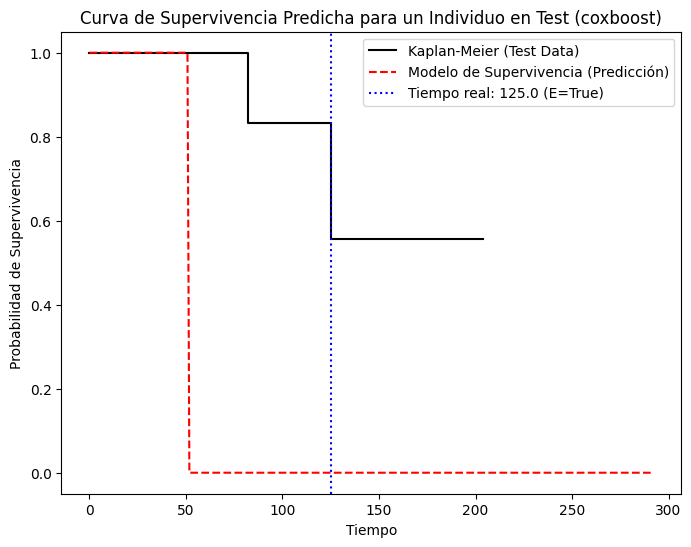

FECHA                     2018-10-02 00:00:00
Caudal                            5318.713265
TPH                                4091.05735
% Solido                            78.409096
Presion                              9.655114
Bateria                              BHC 1012
Ciclón                                    CyH
Medicion                                240.0
horometro                        18128.314453
camino_id                 1012 CyH_2018-05-30
uso_230                              7.357484
TPH_acum                           16364.2294
dias_230                                  125
solido_uso                         938.190204
carga_solidos_efectiva            2657.973307
ratio_tph_caudal                     0.769182
solido_presion                     757.048743
score                                0.030656
score_out                                   0
E                                           1
Name: 25, dtype: object

In [84]:
# Definir la semilla de aleatoriedad
RS = 5

# Seleccionar un individuo aleatorio por posición
random_position = np.random.RandomState(seed=RS).randint(0, len(X_test))
sample_subject = X_test.iloc[[random_position]].copy()

# Obtener los valores correspondientes en y_test usando .iloc
real_time = y_test[random_position]["tiempo"]
real_event = y_test[random_position]["evento"]

# Predicción de la curva de supervivencia para el individuo
sf_pred = coxboost.predict_survival_function(sample_subject)[0]

# Definir el grid de tiempos dentro del dominio permitido por la función de supervivencia
time_grid = np.linspace(0, sf_pred.x[-1], 300)

# Kaplan-Meier en el conjunto de test
kmf = KaplanMeierFitter()
kmf.fit(y_test["tiempo"], event_observed=y_test["evento"])

plt.figure(figsize=(8, 6))

# Curva Kaplan-Meier
plt.step(kmf.survival_function_.index,
         kmf.survival_function_["KM_estimate"],
         where="post", label="Kaplan-Meier (Test Data)", color="black")

# Curva de supervivencia estimada por el modelo
plt.plot(time_grid, sf_pred(time_grid).flatten(),
         label="Modelo de Supervivencia (Predicción)", linestyle="--", color="red")

# Línea que indica el tiempo real del individuo
plt.axvline(real_time, color="blue", linestyle=":",
            label=f"Tiempo real: {real_time:.1f} (E={real_event})")

plt.title("Curva de Supervivencia Predicha para un Individuo en Test (coxboost)")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.legend()
plt.show()

display(data.iloc[sample_subject.index[0]])

In [85]:
import pandas as pd

horizonte = 200  # Horizonte de tiempo para evaluar supervivencia

# Aseguramos que X_test no tenga columnas extra que no se usaron en el fit
X_test_clean = X_test.copy()
if "pred_risk" in X_test_clean.columns:
    X_test_clean = X_test_clean.drop(columns=["pred_risk"])

# Predicción de riesgos parciales usando el DataFrame limpio
pred_risk = rsf.predict(X_test_clean)

# Crear una copia para mostrar los resultados y agregar la columna de predicción
X_test_pred = X_test_clean.copy()
X_test_pred["pred_risk"] = pred_risk

# Predicción de la función de supervivencia para cada individuo usando el DataFrame limpio
sf_horizonte = rsf.predict_survival_function(X_test_clean)

# Para cada individuo, calcular la probabilidad de supervivencia en el horizonte definido
surv_probs = [fn(horizonte).flatten()[0] for fn in sf_horizonte]
X_test_pred[f"surv_prob_{horizonte}"] = surv_probs

# Combinar con datos reales
test_summary = X_test_pred.copy()
test_summary["dias_230"] = y_test["tiempo"]
test_summary["E"] = y_test["evento"]

# Seleccionar columnas a mostrar
cols_to_display = ["dias_230", "E", "pred_risk", f"surv_prob_{horizonte}"]
print(f"\n📋 Resumen de predicciones con horizonte = {horizonte} días:")
display(test_summary[cols_to_display].head(10))



📋 Resumen de predicciones con horizonte = 200 días:


,dias_230,E,pred_risk,surv_prob_200
24,118.0,False,7.356786,0.100357
13,70.0,False,7.638619,0.146357
8,82.0,True,7.060000,0.030833
25,125.0,True,5.127500,0.062500
4,41.0,False,3.350000,0.480000
40,167.0,False,2.870000,0.280000
19,79.0,False,5.490000,0.230000
39,97.0,False,5.400643,0.137429
29,204.0,False,2.640000,0.427500


In [86]:
horizonte = 200  # Horizonte de tiempo para evaluar supervivencia

# Aseguramos que X_test no tenga columnas extra que no se usaron en el fit
X_test_clean = X_test.copy()
if "pred_risk" in X_test_clean.columns:
    X_test_clean = X_test_clean.drop(columns=["pred_risk"])

# Predicción de riesgos parciales usando el DataFrame limpio
pred_risk = coxboost.predict(X_test_clean)

# Crear una copia para mostrar los resultados y agregar la columna de predicción
X_test_pred = X_test_clean.copy()
X_test_pred["pred_risk"] = pred_risk

# Predicción de la función de supervivencia para cada individuo usando el DataFrame limpio
sf_horizonte = coxboost.predict_survival_function(X_test_clean)

# Para cada individuo, calcular la probabilidad de supervivencia en el horizonte definido
surv_probs = [fn(horizonte).flatten()[0] for fn in sf_horizonte]
X_test_pred[f"surv_prob_{horizonte}"] = surv_probs

# Combinar con datos reales
test_summary = X_test_pred.copy()
test_summary["dias_230"] = y_test["tiempo"]
test_summary["E"] = y_test["evento"]

# Seleccionar columnas a mostrar
cols_to_display = ["dias_230", "E", "pred_risk", f"surv_prob_{horizonte}"]
print(f"\n📋 Resumen de predicciones con horizonte = {horizonte} días:")
display(test_summary[cols_to_display].head(10))



📋 Resumen de predicciones con horizonte = 200 días:


,dias_230,E,pred_risk,surv_prob_200
24,118.0,False,-22.716827,0.0
13,70.0,False,-21.214764,0.0
8,82.0,True,-21.411966,0.0
25,125.0,True,-22.980603,0.0
4,41.0,False,-21.227453,0.0
40,167.0,False,-24.734315,0.0
19,79.0,False,-18.560520,0.0
39,97.0,False,-23.246534,0.0
29,204.0,False,-23.813200,0.0
